In [1]:
import json

import bz2
import regex
from tqdm import tqdm_notebook

from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with open('banki_responses.json', 'r') as thefile:
    for row in tqdm_notebook(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

# Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


In [7]:
df['title'].value_counts()[:7]

                        1223
Претензия                364
Кредитная карта          317
Жалоба                   286
Благодарность            248
Звонки из банка          203
Банкомат съел деньги     176
Name: title, dtype: int64

### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [8]:
len(df)

153499

In [9]:
df['city'].value_counts()[:10]

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: city, dtype: int64

In [10]:
len(df['text'][10])

1536

In [11]:
df['bank_name'].value_counts()[:10]

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: bank_name, dtype: int64

### 2. Постройте гистограмы длин слов в символах и в словах.
### *Прим.: Вероятно, имеется ввиду гистограммы тесктов в символах и в словах.*

### *В символах.*

(0, 8000)

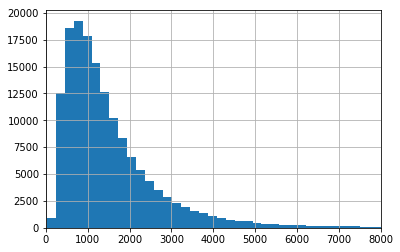

In [12]:
df['text'].apply(len).hist(bins=150)

plt.xlim(0, 8000)

### *В словах. Для начала проведем токенизацию.*

In [13]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df['text'] = df.text.apply(lambda x: x.lower())
df['words_only'] = df.text.apply(words_only)

In [14]:
df['tokenized_sents'] = df.words_only.apply(lambda x: x.split(' '))

In [15]:
df['tokenized_sents_len'] = df['tokenized_sents'].apply(len)

(0, 1000)

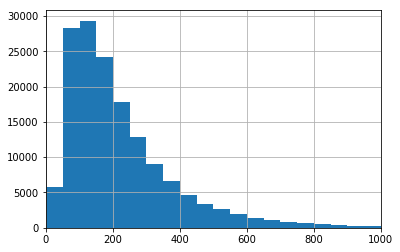

In [16]:
df['tokenized_sents_len'].hist(bins=100)

plt.xlim(0, 1000)

### И в том и в другом случае мы получаем эксп. распределение.

### 3. Найдите 10 самых частых:
        
* слов
* слов без стоп-слов
* лемм 
* существительных

In [17]:
from collections import Counter

In [18]:
def counter(how):
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens = []
    for index, row in tqdm_notebook(df.iterrows(), total = len(df)):
        tokens = row[how].split()
        cnt.update(tokens)
        n_types.append(len(cnt))
        n_tokens.append(sum(cnt.values()))
    for i in cnt.most_common(10):
        print(i)

In [19]:
counter('words_only')


('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


### Как видно, основные слова это предлоги и слово "банк", так как тексты о банках. Избавимся от слоп-слов.

In [20]:
from nltk.corpus import stopwords
sw = stopwords.words('russian') + ['т', 'д', 'это']

In [21]:
def  remove_stopwords(text, mystopwords = sw):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [22]:
df['words_only_without_sw']= df['words_only'].apply(remove_stopwords) 

In [23]:
counter('words_only_without_sw')


('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


### Теперь лемматизация

In [24]:
from pymorphy2 import MorphAnalyzer

pm2 = MorphAnalyzer()


def lemmatize(text, mystem=pm2):
    try:
        return ' '.join([pm2.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "

### Возьмем первые 1000 текстов, так как текстов слишком много.

In [25]:
df['lemmas'] = df['words_only_without_sw'][:1000].apply(lemmatize) 

In [26]:
df['lemmas'] = df['lemmas'].fillna('')

In [27]:
 counter('lemmas')


('банка', 2366)
('карта', 1801)
('банк', 1713)
('год', 1068)
('кредит', 937)
('мой', 895)
('который', 865)
('деньга', 853)
('вклад', 817)
('день', 811)


### Как видно, есть проблема того, что отличает леммы "банка" и "банк", хотя это одно и тоже слово в нашем контексте.

### 4. Постройте кривые Ципфа и Хипса

In [28]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm_notebook(df.iterrows(), total = len(df)):
    tokens = row['words_only'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

### Кривая Ципфа.

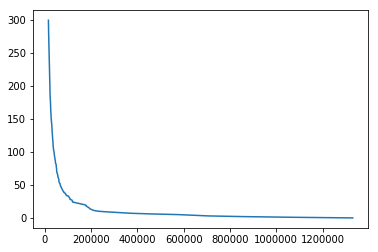

In [29]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Кривая Хипса

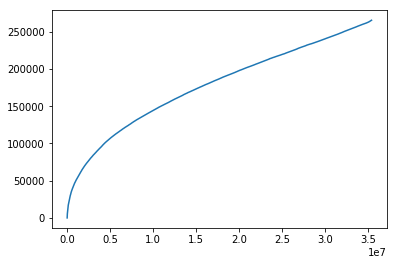

In [30]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

In [31]:
client_count = 0
emp_count = 0
fr_count = 0
tr_count = 0
for key, value in tqdm_notebook(cnt.items()):
    if lemmatize(key) == 'сотрудник':
        emp_count += value
    elif lemmatize(key) == 'клиент':
        client_count += value
    elif lemmatize(key) == 'мошенничество':
        fr_count += value
    elif lemmatize(key) == 'доверие':
        tr_count += value

In [32]:
print('Количество упоминаний клиента: {}, сотрудника: {}'.format(client_count, emp_count))

Количество упоминаний клиента: 136893, сотрудника: 134168


In [33]:
print('Количество упоминаний слово мошенничество: {}, слово доверие: {}'.format(fr_count, tr_count))

Количество упоминаний слово мошенничество: 3244, слово доверие: 2108


### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [34]:
tokens_with_rat_1 = []
tokens_with_rat_5 = []
for i in df[df['rating_grade'] == 1]['lemmas']:
    tokens_with_rat_1 += i.split()
for i in df[df['rating_grade'] == 5]['lemmas']:
    tokens_with_rat_5 += i.split()

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def tfidf(tokens_list, N_min, N_max):
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(N_min, N_max), min_df = 0)
    tfidf_matrix =  tfidf.fit_transform([' '.join(tokens_list)])
    feature_names = tfidf.get_feature_names() 
    tfidf_ranking = []
    dense = tfidf_matrix.todense()

    text = dense.tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    phrases = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
        tfidf_ranking.append(phrase)
    return tfidf_ranking

In [36]:
rankings = pd.DataFrame({'tf-idf': tfidf(tokens_with_rat_1, 1, 1)})
rankings.head(10)

,tf-idf
0,банка
1,карта
2,банк
3,деньга
4,отделение
5,год
6,сотрудник
7,день
8,который
9,мой


In [37]:
rankings = pd.DataFrame({'tf-idf': tfidf(tokens_with_rat_1, 2, 2)})
rankings.head(10)

,tf-idf
0,сотрудник банка
1,отделение банка
2,денежный средство
3,горячий линия
4,кредитный карта
5,написать заявление
6,альфа банк
7,дебетовый карта
8,тысяча рубль
9,добрый день


In [38]:
rankings = pd.DataFrame({'tf-idf': tfidf(tokens_with_rat_5, 1, 1)})
rankings.head(10)

,tf-idf
0,карта
1,банка
2,банк
3,очень
4,вклад
5,клиент
6,который
7,документ
8,дать
9,отделение


In [39]:
rankings = pd.DataFrame({'tf-idf': tfidf(tokens_with_rat_5, 2, 2)})
rankings.head(10)

,tf-idf
0,сч тот
1,отделение банка
2,сбербанк онлайн
3,сотрудник банка
4,вклад доходный
5,год назад
6,горячий линия
7,дебетовый карта
8,занять минута
9,интернет банка


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [40]:
df['title'].value_counts()[1:7]

Претензия               364
Кредитная карта         317
Жалоба                  286
Благодарность           248
Звонки из банка         203
Банкомат съел деньги    176
Name: title, dtype: int64

In [41]:
from gensim.corpora import *
texts = [df[:15000].lemmas.iloc[i].split() for i in range(len(df[:15000]))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [42]:
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [43]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=6)

In [44]:
lsi.show_topics(10)

[(0,
  '0.327*"банка" + 0.303*"карта" + 0.239*"банк" + 0.166*"год" + 0.166*"кредит" + 0.145*"деньга" + 0.144*"вклад" + 0.138*"мой" + 0.129*"день" + 0.128*"который"'),
 (1,
  '-0.615*"вклад" + 0.437*"карта" + -0.243*"ставка" + -0.195*"пополнение" + -0.187*"условие" + -0.169*"договор" + -0.152*"банк" + -0.094*"процент" + -0.090*"вкладчик" + -0.088*"банка"'),
 (2,
  '0.506*"карта" + -0.318*"кредит" + 0.254*"вклад" + -0.220*"звонок" + -0.208*"номер" + -0.176*"ваш" + -0.169*"телефон" + 0.131*"деньга" + -0.127*"сотрудник" + -0.114*"звонить"'),
 (3,
  '0.436*"кредит" + -0.272*"номер" + -0.232*"карта" + -0.229*"звонок" + 0.221*"страховка" + -0.209*"телефон" + 0.198*"сумма" + 0.165*"страхование" + 0.134*"договор" + 0.129*"платёж"'),
 (4,
  '0.436*"карта" + -0.425*"деньга" + 0.283*"кредит" + 0.179*"кредитный" + -0.172*"счёт" + -0.155*"банкомат" + -0.143*"сбербанк" + -0.143*"день" + -0.139*"средство" + -0.117*"отделение"'),
 (5,
  '-0.282*"сумма" + -0.270*"рубль" + 0.227*"отделение" + 0.177*"банк

### Таким образом, тема №1 касается вкладов. Тема №2, вероятно, кредитов. В теме №4 есть упоминание конкретного банка - сбербанка, вероятно там тоже идет речь о кредитах.

In [45]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3,
                        alpha='auto', eta='auto', iterations = 200, passes = 3)

C:\Users\Arsenii\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [46]:
lda.show_topics(15)

[(0,
  '0.017*"банка" + 0.014*"банк" + 0.013*"карта" + 0.008*"год" + 0.008*"вклад" + 0.007*"кредит" + 0.006*"деньга" + 0.006*"сумма" + 0.006*"который" + 0.006*"клиент"'),
 (1,
  '0.013*"банка" + 0.008*"карта" + 0.007*"номер" + 0.006*"мой" + 0.006*"сотрудник" + 0.006*"телефон" + 0.006*"банк" + 0.006*"звонок" + 0.006*"год" + 0.005*"который"'),
 (2,
  '0.001*"кредит" + 0.001*"салон" + 0.001*"досрочный" + 0.001*"банка" + 0.001*"заявление" + 0.000*"банк" + 0.000*"р" + 0.000*"год" + 0.000*"страховка" + 0.000*"погашение"')]

In [47]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\Arsenii\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Тут мы имеем 3 темы - вклады, кредиты, карты.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [48]:
df_ = df[(df['rating_grade']==1) | (df['rating_grade']==5)]
df_['rating_grade'] = df_['rating_grade'].map({1: 0, 5: 1})

C:\Users\Arsenii\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
import pymorphy2
from nltk.tokenize import word_tokenize

class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

morpher = MorphProvider()

from tqdm import tqdm

df_["normalized"] = [morpher.morph_string(t) for t in tqdm(df_.text)]

df_["normalized_words"] = df_.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

100%|███████████████████████████████████████████████████████████████████████████| 62100/62100 [03:44<00:00, 276.07it/s]
C:\Users\Arsenii\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Arsenii\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
df_ = df_.drop(['city', 'author', 'bank_license', 'datetime', 'rating_not_checked', 'title', 'words_only',
                'tokenized_sents', 'text', 'lemmas', 'words_only_without_sw'], axis=1)

In [51]:
df_ = pd.get_dummies(df_, columns=['bank_name'])

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_['normalized_words'][:5000]).toarray()
y = df_['rating_grade'][:5000]

In [53]:
from sklearn.feature_extraction.text import TfidfTransformer

X = TfidfTransformer().fit_transform(X)
X.shape

(5000, 19874)

In [54]:
feature_names = vectorizer.get_feature_names()

In [55]:
X = pd.DataFrame(X.toarray())

In [56]:
df_ = df_.drop(['normalized_words', 'normalized', 'rating_grade'], axis=1)

In [57]:
our_df = df_[:8000].reset_index().drop(['index'], axis=1)

In [58]:
X = X.merge(our_df, left_index=True, right_index=True)

In [59]:
X.shape

(5000, 20456)

In [60]:
columns = X.columns

In [61]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [62]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost

In [63]:
clf = xgboost.XGBClassifier(
                    max_depth=5,
                    n_jobs=-1,
                    n_estimators=101,
                    min_samples_split=200,
                    learning_rate=0.079,
                    max_features='log2',
                    subsample=0.6578947368421052
)

In [64]:
clf.fit(X=X_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       learning_rate=0.079, max_delta_step=0, max_depth=5,
       max_features='log2', min_child_weight=1, min_samples_split=200,
       missing=None, n_estimators=101, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.6578947368421052, verbosity=1)

In [65]:
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

In [66]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [67]:
accuracy_score(y_test, y_test_predict)

0.951

In [68]:
f1_score(y_test, y_test_predict)

0.8361204013377926

In [69]:
roc_auc_score(y_test, y_test_predict)

0.88045143952798

### Таким образом accuracy равен 95%